# Clasificación de animales

Mariana Michell Flores Monroy

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Como ya nos habían comentado, este clafisicador es similar al anterior (el de las flores). Entonces importamos las bibliotecas que se van a necesitar (fastai, pytorch).

In [2]:
import fastai as fai
import fastai.vision as fv
from pathlib import Path 

# Cargar los datos

Algo que si va a cambiar es la carga de los datos, ya que no vienen divididos ni en clases (labels), ni el conjuntos de train & valid.

Guardamos la carpeta de images en una nueva variable (Mascotas) para poder separar las imagenes en los conjuntos que necesitamos.

In [3]:
Mascotas = Path("images")

Una ves más, usaremos el metodo transform para realizar transformadas de las imagenes, en este caso no vamos a usar flip_vert ya que no queremos voltear verticalmente la imagen, ya que son animales y sería raro ver a un perro de cabeza o algo así. max_rotate es qué tanto se puede rotar la imagen, en este caso lo dejaremos bajo, ya que no es tan necesario.

In [4]:
transformaciones = fv.get_transforms(flip_vert=False, max_rotate = 30,
                         max_zoom=1.25, max_lighting=0.3)

Con esta función vamos a crear una lista de las imagenes para posteriormente poder dividirlas en los conjuntos que necesitamos.

In [5]:
datos = fv.ImageItemList.from_folder(Mascotas)

Una vez hecho eso, usamos la función random_split_by_pct() para dividir automaticamente las imagenes en conjuntos de train valid.

In [6]:
data = datos.random_split_by_pct()

In [7]:
data # vemos que los conjuntos ya están divididos

ItemLists;

Train: ImageItemList (5912 items)
[Image (3, 500, 468), Image (3, 375, 500), Image (3, 334, 500), Image (3, 375, 500), Image (3, 333, 500)]...
Path: images;

Valid: ImageItemList (1478 items)
[Image (3, 334, 500), Image (3, 375, 500), Image (3, 375, 500), Image (3, 225, 300), Image (3, 333, 500)]...
Path: images;

Test: None

En esta parte vamos a separar por categorias a las imagenes

In [8]:
data = data.label_from_func(lambda x:"_".join(x.name.split("_")[:-1]))

En la variable "datos" se cargan las imagenes ya con un tamaño de 224 pixeles con un batch size de 64. Y vemos que ya se puede trabajar con las imagenes.

In [9]:
datos = data.transform(transformaciones, size=224).databunch (bs=64).normalize(fv.imagenet_stats)

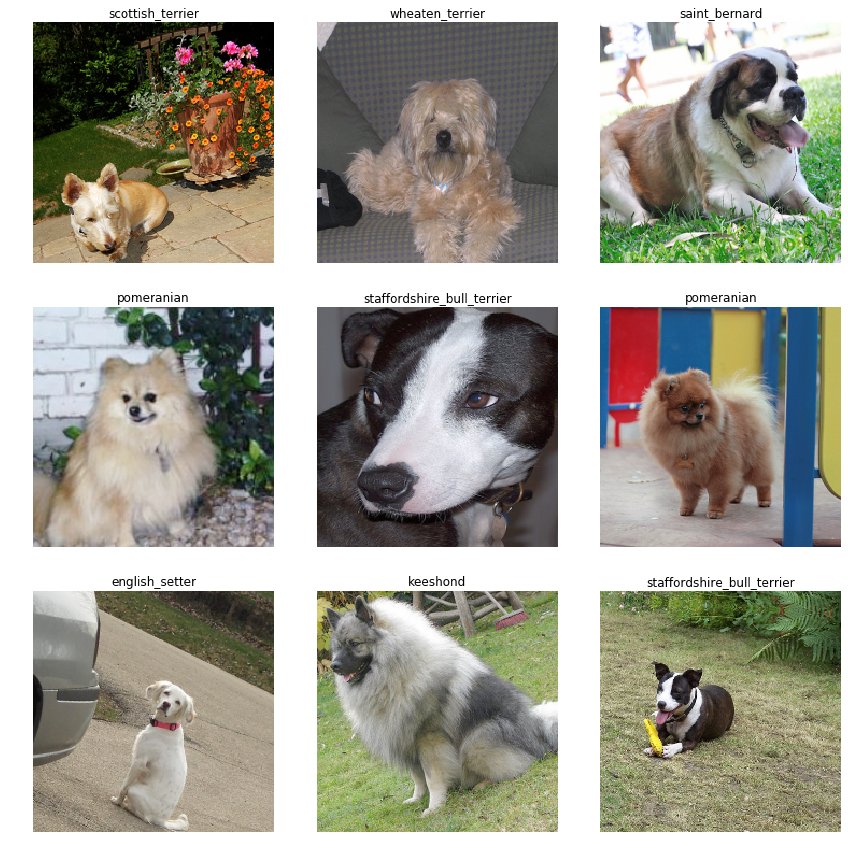

In [10]:
datos.show_batch(rows=3)

# Entrenamiento

Como ya expliqué en la tarea pasada, vamos a generar un learner (el nombre será el mismo para que sea más fácil su entendmiento).

In [11]:
learner = fv.create_cnn(datos, fv.models.resnet18, 
                        metrics=[fai.metrics.accuracy, fai.metrics.error_rate], wd=0.1)

Y usamos el fit_one_cycle para un entrenamiento "superficial"

In [12]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate
1,1.023029,0.378710,0.889039,0.110961


In [13]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.551096,0.290482,0.912043,0.087957
2,0.501058,0.278212,0.911367,0.088633
3,0.392083,0.240467,0.930988,0.069012
4,0.321370,0.231731,0.935047,0.064953


Ahora bien, graficamos la taza de aprendizaje. Y podemos ver que de nuevo la taza de aprendizaje más conveniente se encunetra en 1e-2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


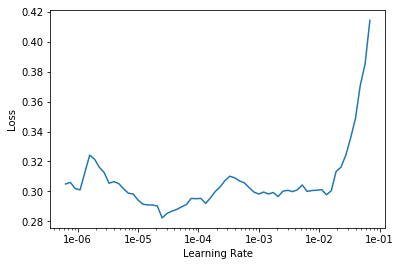

In [14]:
learner.lr_find(); learner.recorder.plot()

In [15]:
learner.fit_one_cycle(4, max_lr = 1e-2)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.518382,1.029711,0.699594,0.300406
2,0.792410,0.495735,0.836942,0.163058
3,0.537095,0.314842,0.899188,0.100812
4,0.384975,0.256312,0.920839,0.079161


Como podemos ver, la red ha dado mejores resultados con esa taza de aprendizaje, así que guardamos el estado de la red.

In [16]:
learner.save('stage1') 

Como podemos ver en la gráfica, a medida que se procesan los baches, los errores disminuyen, lo cual es buena señal.

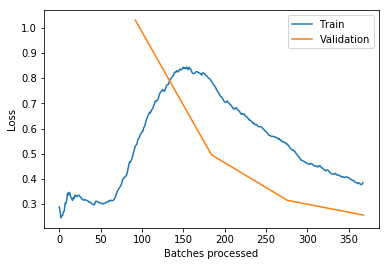

In [17]:
learner.recorder.plot_losses()

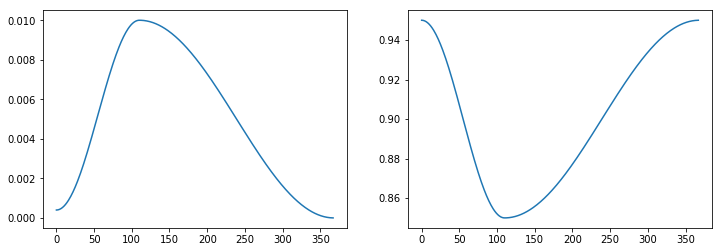

In [18]:
learner.recorder.plot_lr(show_moms=True)

Igual que en el ejercicio pasado, vamos a descongelar la red, para entrenarla completamente.

In [19]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


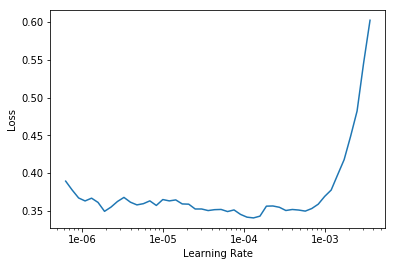

In [20]:
learner.lr_find(); learner.recorder.plot() #graficamos el learning rate

Vemos que en este caso, se produce un menor error con una taza de 1e-6, y ese vamos a usar.

In [21]:
learner.fit_one_cycle(5, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.331988,0.254508,0.922192,0.077808
2,0.329565,0.254273,0.921516,0.078484
3,0.322930,0.251087,0.921516,0.078484
4,0.315038,0.250748,0.918809,0.081191
5,0.324304,0.253907,0.920839,0.079161


In [22]:
learner.save('stage2') #Salvamos el nuevo estado de la red

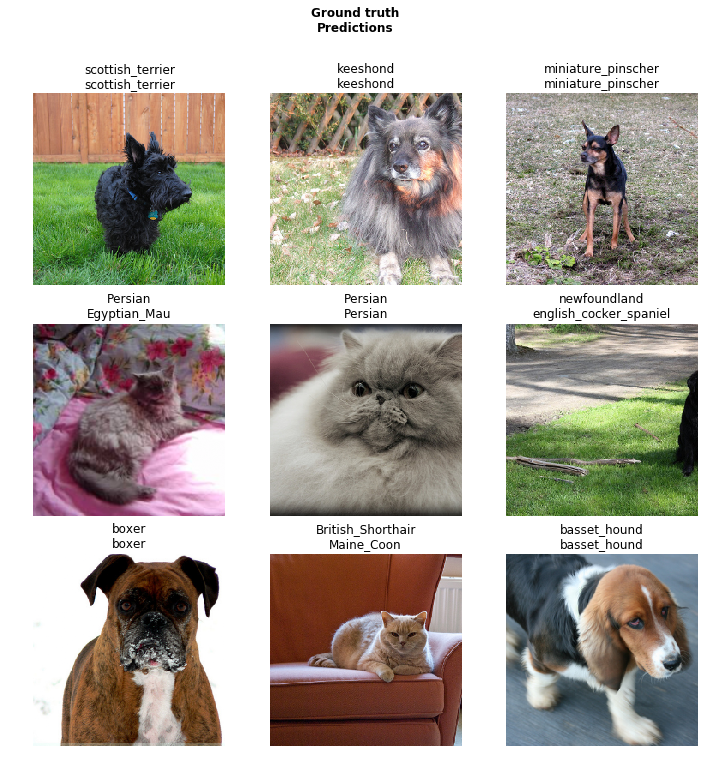

In [23]:
learner.show_results(ds_type=fai.data_block.DatasetType.Valid, rows=3)

In [24]:
fai.metrics.accuracy(*learner.TTA())

tensor(0.9310)

Checamos el accuracy de la red y vemos que tuvo en porcentaje de 93.1% lo cual cumple con el requerimiento básico de la tarea.

In [25]:
interpretacion = learner.interpret()

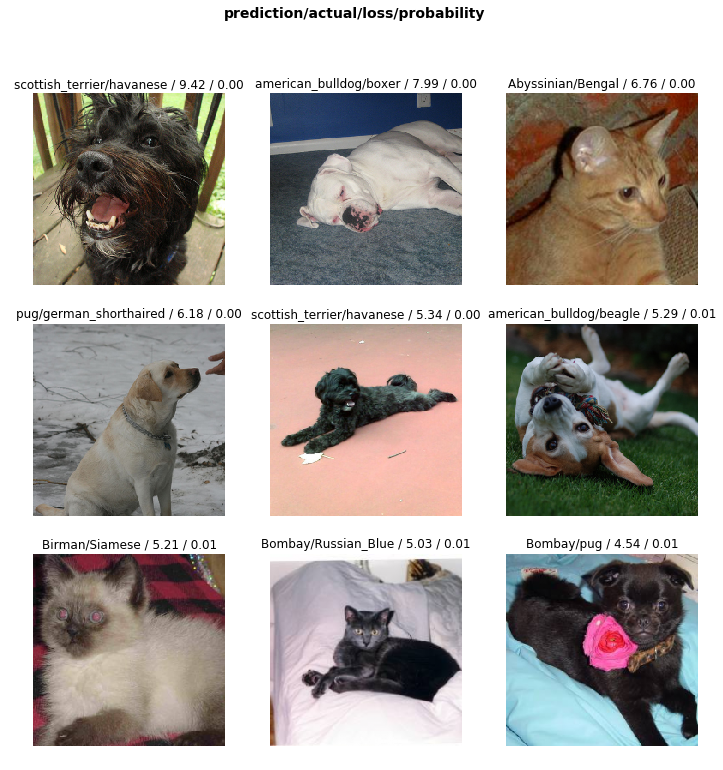

In [26]:
interpretacion.plot_top_losses(9)

# Conclusión

Como lo comenté en la tarea pasada, algo importante en las redes neuronales es saber como manejar los datos antes de procesarlos. En el caso de las mascotas no es tan necesario hacer una transformación de 360° en la rotación de imagenes. 

Ya que se trata de un dataset de mascotas, es importante entender que no es estrictamente necesario que las imagenes se roten totalmente, puesto que no es común identificar un perro inclinado, por ejemplo.